In [ ]:
!pip install shap
!pip install imbalanced-learn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
import pickle

In [ ]:
df = pd.read_csv('/content/aac_intakes_outcomes.csv', on_bad_lines='skip')

In [ ]:
def agrupar_racas(raca):
    raca = raca.replace(" Mix", "").strip()
    if "/" in raca:
        raca = raca.split("/")[0].strip()
    return raca

df['breed_grouped'] = df['breed'].apply(agrupar_racas)

In [ ]:
def exibir_racas_agrupadas():
    racas_agrupadas = df['breed_grouped'].value_counts()
    print("\nRaças agrupadas e suas contagens:")
    print(racas_agrupadas.head(10))

exibir_racas_agrupadas()


Raças agrupadas e suas contagens:
breed_grouped
Domestic Shorthair       23817
Pit Bull                  6865
Labrador Retriever        6260
Chihuahua Shorthair       5726
German Shepherd           2612
Domestic Medium Hair      2464
Bat                       2208
Australian Cattle Dog     1442
Domestic Longhair         1298
Dachshund                 1239
Name: count, dtype: int64


In [ ]:
def categorizar_outcome(outcome):
    if outcome in ['Euthanasia', 'Died']:
        return 'Morto'
    elif outcome == 'Adoption':
        return 'Adotado'
    else:
        return 'Não Adotado'

df['status'] = df['outcome_type'].apply(categorizar_outcome)

In [ ]:
selected_columns = ['age_upon_intake_(years)', 'intake_condition', 'animal_type', 'breed_grouped',
                    'color', 'sex_upon_intake', 'time_in_shelter_days', 'status']

df = df[selected_columns]
df = df.dropna()

In [ ]:
def agrupar_cores_simplificado(color):
    cores_principais = ['Black', 'White', 'Brown', 'Yellow', 'Blue', 'Red', 'Gray']
    for cor in cores_principais:
        if color.startswith(cor):
            return cor
    return 'Other'

df['color_grouped'] = df['color'].apply(agrupar_cores_simplificado)

agrupamento_cores_final = df['color_grouped'].value_counts()

agrupamento_cores_final

,count
color_grouped,
Other,21584
Black,19987
Brown,17169
White,10190
Blue,5976
Red,2468
Gray,1561
Yellow,736


In [ ]:
traducoes = {
    "time_in_shelter_days": "Tempo no Abrigo (dias)",
    "age_upon_intake_(years)": "Idade na Entrada (anos)",
    "sex_upon_intake_Unknown": "Sexo na Entrada: Desconhecido",
    "intake_condition_Normal": "Condição de Entrada: Normal",
    "animal_type_Cat": "Tipo de Animal: Gato",
    "sex_upon_intake_Spayed Female": "Sexo na Entrada: Fêmea Esterilizada",
    "sex_upon_intake_Neutered Male": "Sexo na Entrada: Macho Esterilizado",
    "breed_grouped_Pit Bull": "Raça: Pit Bull",
    "animal_type_Dog": "Tipo de Animal: Cachorro",
    "breed_grouped_Bat": "Raça: Morcego",
    "sex_upon_intake_Intact Male": "Sexo na Entrada: Macho Intacto",
    "intake_condition_Injured": "Condição de Entrada: Ferido",
    "color_Black": "Cor: Preto",
    "breed_grouped_Raccoon": "Raça: Guaxinim",
    "breed_grouped_Domestic Shorthair": "Raça: Doméstico de Pelo Curto",
    "intake_condition_Other": "Condição de Entrada: Outra",
    "breed_grouped_Chihuahua Shorthair": "Raça: Chihuahua de Pelo Curto",
    "breed_grouped_Dachshund": "Raça: Dachshund",
    "intake_condition_Nursing": "Condição de Entrada: Amamentando",
    "animal_type_Other": "Tipo de Animal: Outro",
    "color_group_brown": "Cor: Marrom",
    "color_group_white": "Cor: Branco",
    "intake_condition_Sick": "Condição de Entrada: Doente",
    "color_Black/White": "Cor: Preto/Branco",
    "color_group_others": "Cor: Outras",
    "breed_grouped_Labrador Retriever": "Raça: Labrador Retriever",
    "color_Black/Brown": "Cor: Preto/Marrom",
    "color_group_blue": "Cor: Azul"
}

In [ ]:
def traduzir_labels(features, traducoes):
    return [traducoes.get(feature, feature) for feature in features]

In [ ]:
X = df.drop(columns=['status'])
y = df['status']

In [ ]:
X_encoded = pd.get_dummies(X, drop_first=True)

In [ ]:
le = LabelEncoder()
le.fit(['Não Adotado', 'Adotado', 'Morto'])  # Incluir todas as classes possíveis

y_encoded = le.transform(y)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

In [ ]:
sm = SMOTE(random_state=42)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [ ]:
def exibir_resultados(modelo, nome_modelo):
    y_pred = modelo.predict(x_test)
    y_pred_decoded = le.inverse_transform(y_pred)  # Decodificar rótulos para as classes originais

    print(f"\nRelatório de Classificação - {nome_modelo}")
    print(classification_report(le.inverse_transform(y_test), y_pred_decoded, target_names=le.classes_))

    cm = confusion_matrix(le.inverse_transform(y_test), y_pred_decoded, labels=le.classes_)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'{nome_modelo} - Matriz de Confusão')
    plt.xlabel('Classe Prevista')
    plt.ylabel('Classe Verdadeira')
    plt.show()

    print(f"Acurácia - {nome_modelo}: {accuracy_score(le.inverse_transform(y_test), y_pred_decoded)}")

In [ ]:
def exibir_shap_barras_empilhadas(modelo, x_test, nome_modelo, traducoes, le_classes, top_n=10):
    x_test_amostra = x_test.sample(n=100, random_state=42)

    x_test_amostra_traduzido = x_test_amostra.rename(columns=traducoes)

    explainer = shap.TreeExplainer(modelo)
    shap_values = explainer.shap_values(x_test_amostra)

    if len(shap_values.shape) == 3:
        df_shap_summary = pd.DataFrame(index=x_test_amostra_traduzido.columns)

        for i, classe in enumerate(le_classes):
            shap_abs_values = np.abs(shap_values[:, :, i]).mean(axis=0)
            df_shap_summary[classe] = shap_abs_values

        df_shap_summary['Total'] = df_shap_summary.sum(axis=1)
        df_shap_summary = df_shap_summary.sort_values(by='Total', ascending=False).head(top_n)

        df_shap_summary = df_shap_summary.drop(columns=['Total'])

        df_shap_summary.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab10')
        plt.title(f"SHAP Importância das Features por Classe (Top {top_n}) - {nome_modelo}")
        plt.ylabel("Importância SHAP (Média Absoluta)")
        plt.xlabel("Features")
        plt.legend(title="Classe")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()
    else:
        print("Formato inesperado de shap_values:", shap_values.shape)



Relatório de Classificação - Random Forest
              precision    recall  f1-score   support

     Adotado       0.72      0.76      0.74     10079
       Morto       0.72      0.65      0.68      2080
 Não Adotado       0.75      0.73      0.74     11743

    accuracy                           0.73     23902
   macro avg       0.73      0.71      0.72     23902
weighted avg       0.73      0.73      0.73     23902



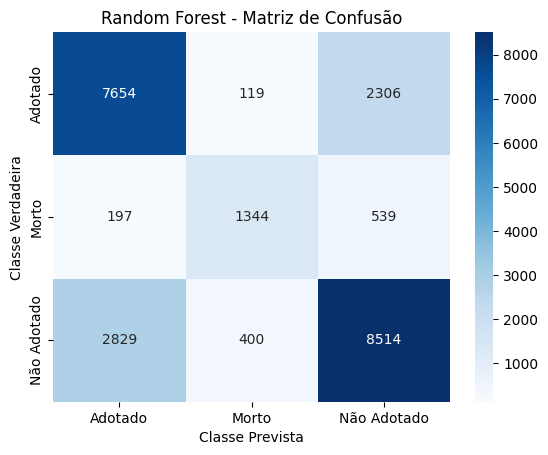

Acurácia - Random Forest: 0.7326583549493766


In [ ]:
# 8. Treinamento do modelo Random Forest
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(x_train_res, y_train_res)
exibir_resultados(model_rf, "Random Forest")


Relatório de Classificação - Decision Tree
              precision    recall  f1-score   support

     Adotado       0.71      0.71      0.71     10079
       Morto       0.60      0.67      0.64      2080
 Não Adotado       0.73      0.71      0.72     11743

    accuracy                           0.71     23902
   macro avg       0.68      0.70      0.69     23902
weighted avg       0.71      0.71      0.71     23902



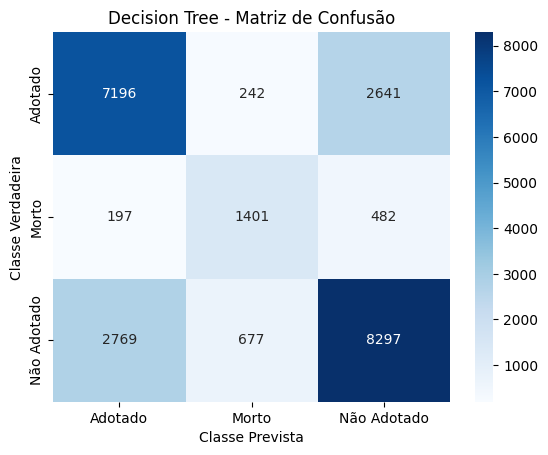

Acurácia - Decision Tree: 0.7068027780102083


In [ ]:
# 9. Treinamento do modelo Decision Tree
model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(x_train_res, y_train_res)
exibir_resultados(model_dt, "Decision Tree")


Relatório de Classificação - XGBoost
              precision    recall  f1-score   support

     Adotado       0.72      0.84      0.78     10079
       Morto       0.79      0.68      0.73      2080
 Não Adotado       0.80      0.71      0.75     11743

    accuracy                           0.76     23902
   macro avg       0.77      0.74      0.75     23902
weighted avg       0.77      0.76      0.76     23902



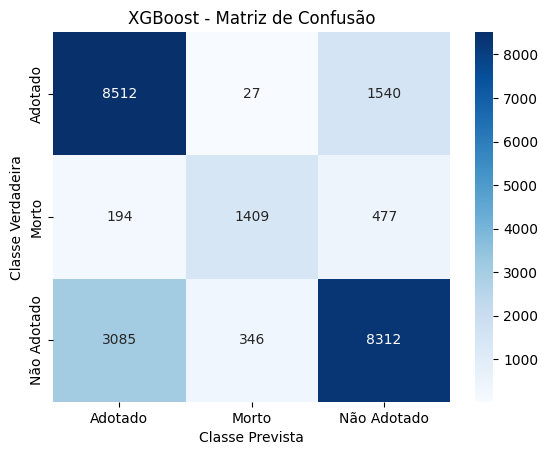

Acurácia - XGBoost: 0.7628231947117396


In [ ]:
# Treinamento do modelo XGBoost
model_xgb = XGBClassifier(objective="multi:softprob", num_class=3, random_state=42)
# Remover o escalonamento
model_xgb.fit(x_train_res, y_train_res)
exibir_resultados(model_xgb, "XGBoost")

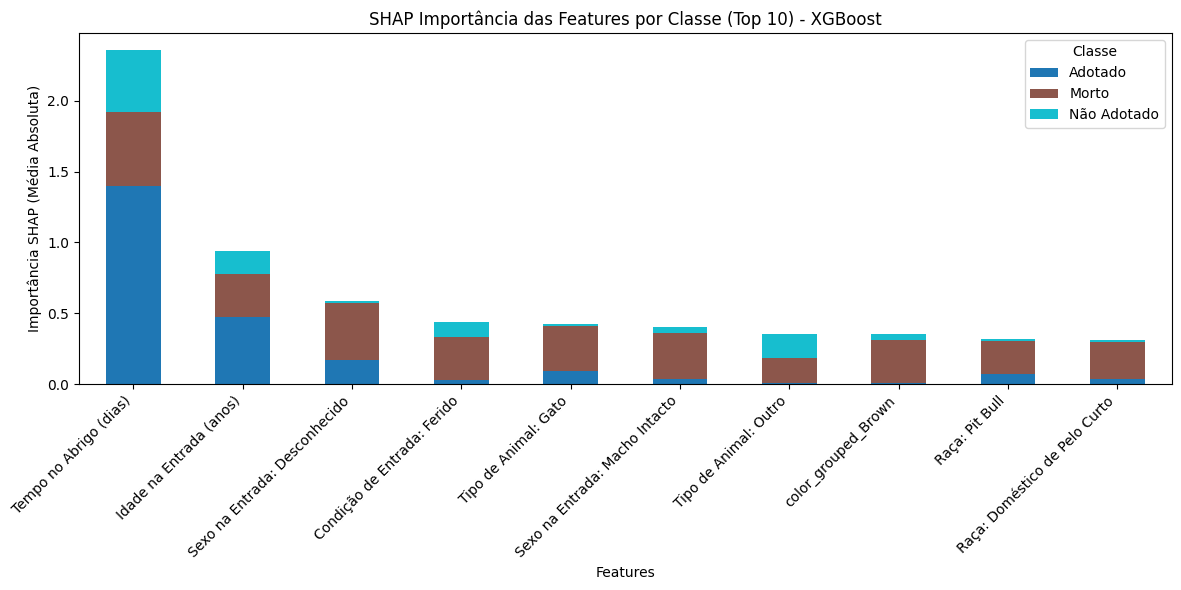

In [ ]:
# Exibir o SHAP plot para XGBoost
exibir_shap_barras_empilhadas(model_xgb, x_test, "XGBoost", traducoes, le.classes_, top_n=10)

In [ ]:
# Converter para NumPy se necessário
if isinstance(x_train_res, pd.DataFrame) or isinstance(x_train_res, pd.Series):
    x_train_res = x_train_res.to_numpy()
if isinstance(y_train_res, pd.DataFrame) or isinstance(y_train_res, pd.Series):
    y_train_res = y_train_res.to_numpy()

# Definir o KFold com 5 divisões
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Iterar sobre os modelos
for nome, modelo in modelos.items():
    print(f"\nValidando o modelo: {nome}")
    fold_accuracies = []

    # Validação cruzada manual
    for train_index, test_index in kf.split(x_train_res):
        x_train_fold, x_test_fold = x_train_res[train_index], x_train_res[test_index]
        y_train_fold, y_test_fold = y_train_res[train_index], y_train_res[test_index]

        # Treinar o modelo
        modelo.fit(x_train_fold, y_train_fold)

        # Previsões
        y_pred_fold = modelo.predict(x_test_fold)

        # Calcular a acurácia
        fold_accuracy = accuracy_score(y_test_fold, y_pred_fold)
        fold_accuracies.append(fold_accuracy)

    # Resultados da validação cruzada
    print(f"Acurácias em cada fold: {fold_accuracies}")
    print(f"Acurácia média: {np.mean(fold_accuracies):.4f}")
    print(f"Desvio padrão: {np.std(fold_accuracies):.4f}")



Validando o modelo: Random Forest
Acurácias em cada fold: [0.8126520681265207, 0.8098540145985401, 0.8103406326034063, 0.8114963503649635, 0.8102189781021898]
Acurácia média: 0.8109
Desvio padrão: 0.0010

Validando o modelo: Decision Tree
Acurácias em cada fold: [0.7760948905109489, 0.7842457420924575, 0.7839416058394161, 0.7785888077858881, 0.779683698296837]
Acurácia média: 0.7805
Desvio padrão: 0.0031

Validando o modelo: XGBoost
Acurácias em cada fold: [0.810948905109489, 0.8116180048661801, 0.8123479318734793, 0.8091240875912409, 0.8099756690997567]
Acurácia média: 0.8108
Desvio padrão: 0.0011


In [ ]:
# Salvando todos os modelos em um único arquivo .pkl
modelos_treinados = {
    'RandomForest': model_rf,
    'DecisionTree': model_dt,
    'XGBoost': model_xgb,
    'x_test': x_test,
    'y_test': y_test
}

In [ ]:
# Salvando o dicionário de modelos em um único arquivo .pkl
with open('/content/modelos_treinados.pkl', 'wb') as file:
    pickle.dump(modelos_treinados, file)

# Carregando os modelos e dados para verificar se o salvamento foi bem-sucedido
with open('/content/modelos_treinados.pkl', 'rb') as file:
    modelos_treinados_carregados = pickle.load(file)

# Exibindo os modelos e dados carregados para confirmar que foram salvos corretamente
for nome, conteudo in modelos_treinados_carregados.items():
    if nome in ['x_train', 'y_train', 'x_test', 'y_test']:
        print(f"{nome} carregado com sucesso: Conjunto de dados")
    else:
        print(f"{nome} carregado com sucesso: {conteudo}")

RandomForest carregado com sucesso: RandomForestClassifier(random_state=42)
DecisionTree carregado com sucesso: DecisionTreeClassifier(random_state=42)
XGBoost carregado com sucesso: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)
x_test carregado com sucesso: Conjunto de dados
y_test carregado 

In [ ]:
# Testando a previsão com o modelo carregado do Gradient Boosting para garantir que o modelo ainda funciona
modelo_gb_carregado = modelos_treinados_carregados['XGBoost']  # Usando a variável correta

# Carregando o x_test e y_test do arquivo pickle
x_test_carregado = modelos_treinados_carregados['x_test']  # Usando a variável correta
y_test_carregado = modelos_treinados_carregados['y_test']  # Usando a variável correta

# Realizando a previsão
y_pred_carregado = modelo_gb_carregado.predict(x_test_carregado)


ValueError: feature_names mismatch: ['age_upon_intake_(years)', 'time_in_shelter_days', 'intake_condition_Feral', 'intake_condition_Injured', 'intake_condition_Normal', 'intake_condition_Nursing', 'intake_condition_Other', 'intake_condition_Pregnant', 'intake_condition_Sick', 'animal_type_Cat', 'animal_type_Dog', 'animal_type_Other', 'breed_grouped_Affenpinscher', 'breed_grouped_Afghan Hound', 'breed_grouped_African', 'breed_grouped_Airedale Terrier', 'breed_grouped_Akbash', 'breed_grouped_Akita', 'breed_grouped_Alaskan Husky', 'breed_grouped_Alaskan Malamute', 'breed_grouped_American', 'breed_grouped_American Bulldog', 'breed_grouped_American Curl Shorthair', 'breed_grouped_American Eskimo', 'breed_grouped_American Foxhound', 'breed_grouped_American Pit Bull Terrier', 'breed_grouped_American Sable', 'breed_grouped_American Shorthair', 'breed_grouped_American Staffordshire Terrier', 'breed_grouped_American Wirehair', 'breed_grouped_Anatol Shepherd', 'breed_grouped_Angora', 'breed_grouped_Angora-English', 'breed_grouped_Angora-French', 'breed_grouped_Armadillo', 'breed_grouped_Australian Cattle Dog', 'breed_grouped_Australian Kelpie', 'breed_grouped_Australian Shepherd', 'breed_grouped_Australian Terrier', 'breed_grouped_Balinese', 'breed_grouped_Bantam', 'breed_grouped_Barred Rock', 'breed_grouped_Basenji', 'breed_grouped_Basset Hound', 'breed_grouped_Bat', 'breed_grouped_Beagle', 'breed_grouped_Bearded Collie', 'breed_grouped_Beauceron', 'breed_grouped_Bedlington Terr', 'breed_grouped_Belgian Hare', 'breed_grouped_Belgian Malinois', 'breed_grouped_Belgian Sheepdog', 'breed_grouped_Belgian Tervuren', 'breed_grouped_Bengal', 'breed_grouped_Bernese Mountain Dog', 'breed_grouped_Bichon Frise', 'breed_grouped_Birman', 'breed_grouped_Black', 'breed_grouped_Black Mouth Cur', 'breed_grouped_Bloodhound', 'breed_grouped_Blue Lacy', 'breed_grouped_Bluebird', 'breed_grouped_Bluetick Hound', 'breed_grouped_Bobcat', 'breed_grouped_Boerboel', 'breed_grouped_Bombay', 'breed_grouped_Border Collie', 'breed_grouped_Border Terrier', 'breed_grouped_Boston Terrier', 'breed_grouped_Bouv Flandres', 'breed_grouped_Boxer', 'breed_grouped_Boykin Span', 'breed_grouped_Britannia Petit', 'breed_grouped_British Shorthair', 'breed_grouped_Brittany', 'breed_grouped_Bruss Griffon', 'breed_grouped_Budgerigar', 'breed_grouped_Bull Terrier', 'breed_grouped_Bull Terrier Miniature', 'breed_grouped_Bulldog', 'breed_grouped_Bullmastiff', 'breed_grouped_Bunting', 'breed_grouped_Burmese', 'breed_grouped_Cairn Terrier', 'breed_grouped_Californian', 'breed_grouped_Canaan Dog', 'breed_grouped_Cane Corso', 'breed_grouped_Cardigan Welsh Corgi', 'breed_grouped_Carolina Dog', 'breed_grouped_Catahoula', 'breed_grouped_Catbird', 'breed_grouped_Cavalier Span', 'breed_grouped_Chartreux', 'breed_grouped_Checkered Giant', 'breed_grouped_Chesa Bay Retr', 'breed_grouped_Chicken', 'breed_grouped_Chihuahua Longhair', 'breed_grouped_Chihuahua Shorthair', 'breed_grouped_Chinchilla', 'breed_grouped_Chinchilla-Amer', 'breed_grouped_Chinchilla-Stnd', 'breed_grouped_Chinese Crested', 'breed_grouped_Chinese Sharpei', 'breed_grouped_Chow Chow', 'breed_grouped_Cinnamon', 'breed_grouped_Cockatiel', 'breed_grouped_Cockatoo', 'breed_grouped_Cocker Spaniel', 'breed_grouped_Cold Water', 'breed_grouped_Collie Rough', 'breed_grouped_Collie Smooth', 'breed_grouped_Conure', 'breed_grouped_Cornish Rex', 'breed_grouped_Coton De Tulear', 'breed_grouped_Cottontail', 'breed_grouped_Coyote', 'breed_grouped_Crow', 'breed_grouped_Cymric', 'breed_grouped_Dachshund', 'breed_grouped_Dachshund Longhair', 'breed_grouped_Dachshund Stan', 'breed_grouped_Dachshund Wirehair', 'breed_grouped_Dalmatian', 'breed_grouped_Dandie Dinmont', 'breed_grouped_Deer', 'breed_grouped_Devon Rex', 'breed_grouped_Doberman Pinsch', 'breed_grouped_Dogo Argentino', 'breed_grouped_Dogue De Bordeaux', 'breed_grouped_Domestic Longhair', 'breed_grouped_Domestic Medium Hair', 'breed_grouped_Domestic Shorthair', 'breed_grouped_Dove', 'breed_grouped_Duck', 'breed_grouped_Dutch', 'breed_grouped_Dutch Shepherd', 'breed_grouped_Eng Toy Spaniel', 'breed_grouped_English Bulldog', 'breed_grouped_English Cocker Spaniel', 'breed_grouped_English Coonhound', 'breed_grouped_English Foxhound', 'breed_grouped_English Pointer', 'breed_grouped_English Setter', 'breed_grouped_English Shepherd', 'breed_grouped_English Spot', 'breed_grouped_English Springer Spaniel', 'breed_grouped_Entlebucher', 'breed_grouped_Exotic Shorthair', 'breed_grouped_Feist', 'breed_grouped_Ferret', 'breed_grouped_Field Spaniel', 'breed_grouped_Finch', 'breed_grouped_Finnish Spitz', 'breed_grouped_Flat Coat Retriever', 'breed_grouped_Flemish Giant', 'breed_grouped_Fox', 'breed_grouped_French Bulldog', 'breed_grouped_Frog', 'breed_grouped_Gerbil', 'breed_grouped_German Pinscher', 'breed_grouped_German Shepherd', 'breed_grouped_German Shorthair Pointer', 'breed_grouped_German Wirehaired Pointer', 'breed_grouped_Glen Of Imaal', 'breed_grouped_Golden Retriever', 'breed_grouped_Goose', 'breed_grouped_Gordon Setter', 'breed_grouped_Grackle', 'breed_grouped_Grand Basset Griffon Vendeen', 'breed_grouped_Great Dane', 'breed_grouped_Great Pyrenees', 'breed_grouped_Greater Swiss Mountain Dog', 'breed_grouped_Greyhound', 'breed_grouped_Guinea', 'breed_grouped_Guinea Pig', 'breed_grouped_Hamster', 'breed_grouped_Harlequin', 'breed_grouped_Harrier', 'breed_grouped_Havana', 'breed_grouped_Havana Brown', 'breed_grouped_Havanese', 'breed_grouped_Hawk', 'breed_grouped_Hedgehog', 'breed_grouped_Heron', 'breed_grouped_Himalayan', 'breed_grouped_Hotot', 'breed_grouped_Hovawart', 'breed_grouped_Ibizan Hound', 'breed_grouped_Irish Setter', 'breed_grouped_Irish Terrier', 'breed_grouped_Irish Wolfhound', 'breed_grouped_Italian Greyhound', 'breed_grouped_Jack Russell Terrier', 'breed_grouped_Japanese Bobtail', 'breed_grouped_Japanese Chin', 'breed_grouped_Javanese', 'breed_grouped_Jersey Wooly', 'breed_grouped_Jindo', 'breed_grouped_Keeshond', 'breed_grouped_Kuvasz', 'breed_grouped_Labrador Retriever', 'breed_grouped_Lakeland Terrier', 'breed_grouped_Landseer', 'breed_grouped_Lark', 'breed_grouped_Leghorn', 'breed_grouped_Leonberger', 'breed_grouped_Lhasa Apso', 'breed_grouped_Lionhead', 'breed_grouped_Lizard', 'breed_grouped_Lop-Amer Fuzzy', 'breed_grouped_Lop-English', 'breed_grouped_Lop-Holland', 'breed_grouped_Lop-Mini', 'breed_grouped_Lovebird', 'breed_grouped_Lowchen', 'breed_grouped_Maine Coon', 'breed_grouped_Maltese', 'breed_grouped_Manchester Terrier', 'breed_grouped_Manx', 'breed_grouped_Mastiff', 'breed_grouped_Mexican Hairless', 'breed_grouped_Miniature Pinscher', 'breed_grouped_Miniature Poodle', 'breed_grouped_Miniature Schnauzer', 'breed_grouped_Mockingbird', 'breed_grouped_Mouse', 'breed_grouped_Munchkin Longhair', 'breed_grouped_Munchkin Shorthair', 'breed_grouped_Muscovy', 'breed_grouped_Neapolitan Mastiff', 'breed_grouped_Netherlnd Dwarf', 'breed_grouped_New Zealand Wht', 'breed_grouped_Newfoundland', 'breed_grouped_Norfolk Terrier', 'breed_grouped_Norwegian Elkhound', 'breed_grouped_Norwegian Forest Cat', 'breed_grouped_Norwich Terrier', 'breed_grouped_Nova Scotia Duck Tolling Retriever', 'breed_grouped_Nuthatch', 'breed_grouped_Ocicat', 'breed_grouped_Old English Bulldog', 'breed_grouped_Old English Sheepdog', 'breed_grouped_Opossum', 'breed_grouped_Oriental Sh', 'breed_grouped_Otter', 'breed_grouped_Otterhound', 'breed_grouped_Owl', 'breed_grouped_Papillon', 'breed_grouped_Parakeet', 'breed_grouped_Parrot', 'breed_grouped_Parson Russell Terrier', 'breed_grouped_Patterdale Terr', 'breed_grouped_Pbgv', 'breed_grouped_Peafowl', 'breed_grouped_Pekingese', 'breed_grouped_Pembroke Welsh Corgi', 'breed_grouped_Persian', 'breed_grouped_Pharaoh Hound', 'breed_grouped_Pheasant', 'breed_grouped_Picardy Sheepdog', 'breed_grouped_Pigeon', 'breed_grouped_Pit Bull', 'breed_grouped_Pixiebob Shorthair', 'breed_grouped_Plott Hound', 'breed_grouped_Podengo Pequeno', 'breed_grouped_Pointer', 'breed_grouped_Polish', 'breed_grouped_Pomeranian', 'breed_grouped_Port Water Dog', 'breed_grouped_Presa Canario', 'breed_grouped_Pug', 'breed_grouped_Quaker', 'breed_grouped_Queensland Heeler', 'breed_grouped_Rabbit Lh', 'breed_grouped_Rabbit Sh', 'breed_grouped_Raccoon', 'breed_grouped_Ragdoll', 'breed_grouped_Rat', 'breed_grouped_Rat Terrier', 'breed_grouped_Redbone Hound', 'breed_grouped_Rex', 'breed_grouped_Rex-Mini', 'breed_grouped_Rhod Ridgeback', 'breed_grouped_Rhode Island', 'breed_grouped_Ringtail', 'breed_grouped_Rottweiler', 'breed_grouped_Russian Blue', 'breed_grouped_Saluki', 'breed_grouped_Samoyed', 'breed_grouped_Schipperke', 'breed_grouped_Schnauzer Giant', 'breed_grouped_Scottish Fold', 'breed_grouped_Scottish Terrier', 'breed_grouped_Sealyham Terr', 'breed_grouped_Shetland Sheepdog', 'breed_grouped_Shiba Inu', 'breed_grouped_Shih Tzu', 'breed_grouped_Siamese', 'breed_grouped_Siberian Husky', 'breed_grouped_Silkie', 'breed_grouped_Silky Terrier', 'breed_grouped_Silver', 'breed_grouped_Skunk', 'breed_grouped_Skye Terrier', 'breed_grouped_Smooth Fox Terrier', 'breed_grouped_Snake', 'breed_grouped_Snowshoe', 'breed_grouped_Soft Coated Wheaten Terrier', 'breed_grouped_Song Bird', 'breed_grouped_Spanish Mastiff', 'breed_grouped_Sparrow', 'breed_grouped_Sphynx', 'breed_grouped_Spinone Italiano', 'breed_grouped_Squirrel', 'breed_grouped_St. Bernard Rough Coat', 'breed_grouped_St. Bernard Smooth Coat', 'breed_grouped_Staffordshire', 'breed_grouped_Standard Poodle', 'breed_grouped_Standard Schnauzer', 'breed_grouped_Sugar Glider', 'breed_grouped_Sussex Span', 'breed_grouped_Swedish Vallhund', 'breed_grouped_Swiss Hound', 'breed_grouped_Tarantula', 'breed_grouped_Tibetan Spaniel', 'breed_grouped_Tibetan Terrier', 'breed_grouped_Tonkinese', 'breed_grouped_Tortoise', 'breed_grouped_Toy Fox Terrier', 'breed_grouped_Toy Poodle', 'breed_grouped_Treeing Cur', 'breed_grouped_Treeing Tennesse Brindle', 'breed_grouped_Treeing Walker Coonhound', 'breed_grouped_Tropical', 'breed_grouped_Turkey', 'breed_grouped_Turkish Angora', 'breed_grouped_Turkish Van', 'breed_grouped_Turtle', 'breed_grouped_Unknown', 'breed_grouped_Vizsla', 'breed_grouped_Vulture', 'breed_grouped_Weimaraner', 'breed_grouped_Welsh Springer Spaniel', 'breed_grouped_Welsh Terrier', 'breed_grouped_West Highland', 'breed_grouped_Whippet', 'breed_grouped_Wire Hair Fox Terrier', 'breed_grouped_Wirehaired Pointing Griffon', 'breed_grouped_Wren', 'breed_grouped_Yorkshire Terrier', 'color_Agouti/Brown Tabby', 'color_Agouti/Gray', 'color_Agouti/White', 'color_Apricot', 'color_Apricot/Brown', 'color_Apricot/Tricolor', 'color_Apricot/White', 'color_Black', 'color_Black Brindle', 'color_Black Brindle/Black', 'color_Black Brindle/Blue', 'color_Black Brindle/Blue Tick', 'color_Black Brindle/Brown', 'color_Black Brindle/Brown Brindle', 'color_Black Brindle/White', 'color_Black Smoke', 'color_Black Smoke/Black', 'color_Black Smoke/Black Tiger', 'color_Black Smoke/Blue Tick', 'color_Black Smoke/Brown', 'color_Black Smoke/Brown Tabby', 'color_Black Smoke/Gray', 'color_Black Smoke/White', 'color_Black Tabby', 'color_Black Tabby/Black', 'color_Black Tabby/Gray', 'color_Black Tabby/Gray Tabby', 'color_Black Tabby/Orange', 'color_Black Tabby/White', 'color_Black Tiger', 'color_Black Tiger/White', 'color_Black/Black', 'color_Black/Black Brindle', 'color_Black/Black Smoke', 'color_Black/Black Tabby', 'color_Black/Blue', 'color_Black/Blue Merle', 'color_Black/Blue Tick', 'color_Black/Brown', 'color_Black/Brown Brindle', 'color_Black/Brown Merle', 'color_Black/Brown Tabby', 'color_Black/Buff', 'color_Black/Chocolate', 'color_Black/Cream', 'color_Black/Gold', 'color_Black/Gray', 'color_Black/Gray Tabby', 'color_Black/Green', 'color_Black/Orange', 'color_Black/Pink', 'color_Black/Red', 'color_Black/Seal Point', 'color_Black/Silver', 'color_Black/Silver Tabby', 'color_Black/Tan', 'color_Black/Tortie', 'color_Black/Tricolor', 'color_Black/White', 'color_Black/Yellow', 'color_Black/Yellow Brindle', 'color_Blue', 'color_Blue Cream', 'color_Blue Cream/Blue Tabby', 'color_Blue Cream/Blue Tiger', 'color_Blue Cream/Buff', 'color_Blue Cream/Tortie', 'color_Blue Cream/White', 'color_Blue Merle', 'color_Blue Merle/Black', 'color_Blue Merle/Blue Merle', 'color_Blue Merle/Brown', 'color_Blue Merle/Brown Brindle', 'color_Blue Merle/Cream', 'color_Blue Merle/Gray', 'color_Blue Merle/Red', 'color_Blue Merle/Red Merle', 'color_Blue Merle/Tan', 'color_Blue Merle/Tricolor', 'color_Blue Merle/White', 'color_Blue Point', 'color_Blue Point/Cream', 'color_Blue Point/White', 'color_Blue Smoke', 'color_Blue Smoke/Brown', 'color_Blue Smoke/Gray', 'color_Blue Smoke/White', 'color_Blue Tabby', 'color_Blue Tabby/Black', 'color_Blue Tabby/Blue Cream', 'color_Blue Tabby/Buff', 'color_Blue Tabby/Cream', 'color_Blue Tabby/Orange', 'color_Blue Tabby/Tan', 'color_Blue Tabby/White', 'color_Blue Tick', 'color_Blue Tick/Black', 'color_Blue Tick/Brown', 'color_Blue Tick/Brown Brindle', 'color_Blue Tick/Red', 'color_Blue Tick/Red Tick', 'color_Blue Tick/Tan', 'color_Blue Tick/Tricolor', 'color_Blue Tick/White', 'color_Blue Tiger', 'color_Blue Tiger/White', 'color_Blue/Black', 'color_Blue/Blue', 'color_Blue/Brown', 'color_Blue/Brown Brindle', 'color_Blue/Calico', 'color_Blue/Cream', 'color_Blue/Gray', 'color_Blue/Green', 'color_Blue/Orange', 'color_Blue/Silver', 'color_Blue/Tan', 'color_Blue/Tortie', 'color_Blue/Tricolor', 'color_Blue/White', 'color_Blue/Yellow', 'color_Blue/Yellow Brindle', 'color_Brown', 'color_Brown Brindle', 'color_Brown Brindle/Black', 'color_Brown Brindle/Blue', 'color_Brown Brindle/Blue Cream', 'color_Brown Brindle/Blue Tick', 'color_Brown Brindle/Brown', 'color_Brown Brindle/Brown Brindle', 'color_Brown Brindle/Brown Merle', 'color_Brown Brindle/Gray', 'color_Brown Brindle/Red Tick', 'color_Brown Brindle/Tan', 'color_Brown Brindle/White', 'color_Brown Merle', 'color_Brown Merle/Black', 'color_Brown Merle/Blue Merle', 'color_Brown Merle/Brown', 'color_Brown Merle/Brown Tabby', 'color_Brown Merle/Tan', 'color_Brown Merle/White', 'color_Brown Tabby', 'color_Brown Tabby/Agouti', 'color_Brown Tabby/Black', 'color_Brown Tabby/Black Brindle', 'color_Brown Tabby/Blue', 'color_Brown Tabby/Brown', 'color_Brown Tabby/Brown Tabby', 'color_Brown Tabby/Cream', 'color_Brown Tabby/Gray', 'color_Brown Tabby/Gray Tabby', 'color_Brown Tabby/Orange', 'color_Brown Tabby/Orange Tabby', 'color_Brown Tabby/Tortie', 'color_Brown Tabby/White', 'color_Brown Tiger', 'color_Brown Tiger/Brown', 'color_Brown Tiger/White', 'color_Brown/Apricot', 'color_Brown/Black', 'color_Brown/Black Brindle', 'color_Brown/Black Tabby', 'color_Brown/Blue', 'color_Brown/Blue Merle', 'color_Brown/Brown', 'color_Brown/Brown Brindle', 'color_Brown/Brown Merle', 'color_Brown/Brown Tabby', 'color_Brown/Buff', 'color_Brown/Chocolate', 'color_Brown/Cream', 'color_Brown/Gray', 'color_Brown/Green', 'color_Brown/Orange', 'color_Brown/Pink', 'color_Brown/Red', 'color_Brown/Red Merle', 'color_Brown/Red Tick', 'color_Brown/Silver', 'color_Brown/Tan', 'color_Brown/Tricolor', 'color_Brown/White', 'color_Brown/Yellow', 'color_Buff', 'color_Buff/Black', 'color_Buff/Brown', 'color_Buff/Cream', 'color_Buff/Gray', 'color_Buff/Red', 'color_Buff/Tan', 'color_Buff/White', 'color_Buff/Yellow', 'color_Calico', 'color_Calico Point', 'color_Calico Point/Gray', 'color_Calico Point/White', 'color_Calico/Black', 'color_Calico/Blue Cream', 'color_Calico/Blue Tabby', 'color_Calico/Brown', 'color_Calico/Brown Tabby', 'color_Calico/Calico', 'color_Calico/Gray Tabby', 'color_Calico/Orange', 'color_Calico/Orange Tabby', 'color_Calico/Tricolor', 'color_Calico/White', 'color_Chocolate', 'color_Chocolate Point', 'color_Chocolate Point/Cream', 'color_Chocolate Point/White', 'color_Chocolate/Black', 'color_Chocolate/Brown', 'color_Chocolate/Brown Brindle', 'color_Chocolate/Brown Merle', 'color_Chocolate/Brown Tabby', 'color_Chocolate/Chocolate', 'color_Chocolate/Cream', 'color_Chocolate/Gold', 'color_Chocolate/Gray', 'color_Chocolate/Liver Tick', 'color_Chocolate/Red', 'color_Chocolate/Red Tick', 'color_Chocolate/Tan', 'color_Chocolate/Tricolor', 'color_Chocolate/White', 'color_Chocolate/Yellow', 'color_Cream', 'color_Cream Tabby', 'color_Cream Tabby/Cream Tabby', 'color_Cream Tabby/Orange', 'color_Cream Tabby/Orange Tabby', 'color_Cream Tabby/White', 'color_Cream/Black', 'color_Cream/Blue Point', 'color_Cream/Brown', 'color_Cream/Brown Merle', 'color_Cream/Cream', 'color_Cream/Gray', 'color_Cream/Orange', 'color_Cream/Red', 'color_Cream/Red Tick', 'color_Cream/Seal Point', 'color_Cream/Silver', 'color_Cream/Tan', 'color_Cream/White', 'color_Cream/Yellow', 'color_Fawn', 'color_Fawn/Black', 'color_Fawn/Blue', 'color_Fawn/Brown', 'color_Fawn/Brown Brindle', 'color_Fawn/Chocolate', 'color_Fawn/Gray', 'color_Fawn/Tan', 'color_Fawn/Tricolor', 'color_Fawn/White', 'color_Flame Point', 'color_Flame Point/Cream', 'color_Flame Point/White', 'color_Gold', 'color_Gold/Black', 'color_Gold/Brown', 'color_Gold/Buff', 'color_Gold/Cream', 'color_Gold/Gold', 'color_Gold/Gray', 'color_Gold/Tan', 'color_Gold/White', 'color_Gold/Yellow', 'color_Gray', 'color_Gray Tabby', 'color_Gray Tabby/Black', 'color_Gray Tabby/Gray', 'color_Gray Tabby/Orange', 'color_Gray Tabby/White', 'color_Gray/Black', 'color_Gray/Blue', 'color_Gray/Brown', 'color_Gray/Buff', 'color_Gray/Cream', 'color_Gray/Fawn', 'color_Gray/Gold', 'color_Gray/Gray', 'color_Gray/Orange', 'color_Gray/Pink', 'color_Gray/Red', 'color_Gray/Silver', 'color_Gray/Tan', 'color_Gray/Tortie', 'color_Gray/Tricolor', 'color_Gray/White', 'color_Gray/Yellow', 'color_Green', 'color_Green/Black', 'color_Green/Blue', 'color_Green/Brown', 'color_Green/Gray', 'color_Green/Orange', 'color_Green/Red', 'color_Green/White', 'color_Green/Yellow', 'color_Lilac Point', 'color_Lilac Point/Cream', 'color_Lilac Point/White', 'color_Liver', 'color_Liver Tick', 'color_Liver Tick/White', 'color_Liver/Buff', 'color_Liver/Chocolate', 'color_Liver/Tan', 'color_Liver/White', 'color_Lynx Point', 'color_Lynx Point/Blue', 'color_Lynx Point/Brown Tabby', 'color_Lynx Point/Gray Tabby', 'color_Lynx Point/Tan', 'color_Lynx Point/Tortie Point', 'color_Lynx Point/White', 'color_Orange', 'color_Orange Tabby', 'color_Orange Tabby/Apricot', 'color_Orange Tabby/Black', 'color_Orange Tabby/Brown', 'color_Orange Tabby/Cream', 'color_Orange Tabby/Orange', 'color_Orange Tabby/Orange Tabby', 'color_Orange Tabby/Tortie Point', 'color_Orange Tabby/White', 'color_Orange Tiger', 'color_Orange/Black', 'color_Orange/Blue', 'color_Orange/Brown', 'color_Orange/Gray', 'color_Orange/Orange Tabby', 'color_Orange/Tan', 'color_Orange/White', 'color_Pink', 'color_Red', 'color_Red Merle', 'color_Red Merle/Black', 'color_Red Merle/Brown Merle', 'color_Red Merle/Red Merle', 'color_Red Merle/Tan', 'color_Red Merle/White', 'color_Red Tick', 'color_Red Tick/Black', 'color_Red Tick/Blue Tick', 'color_Red Tick/Brown', 'color_Red Tick/Brown Brindle', 'color_Red Tick/Brown Merle', 'color_Red Tick/Red', 'color_Red Tick/Tan', 'color_Red Tick/White', 'color_Red/Black', 'color_Red/Blue', 'color_Red/Brown', 'color_Red/Buff', 'color_Red/Cream', 'color_Red/Gold', 'color_Red/Gray', 'color_Red/Green', 'color_Red/Red', 'color_Red/Red Merle', 'color_Red/Red Tick', 'color_Red/Silver', 'color_Red/Tan', 'color_Red/Tricolor', 'color_Red/White', 'color_Red/Yellow', 'color_Ruddy/Cream', 'color_Sable', 'color_Sable/Black', 'color_Sable/Brown', 'color_Sable/Buff', 'color_Sable/Cream', 'color_Sable/Gray', 'color_Sable/Red', 'color_Sable/Red Merle', 'color_Sable/Tan', 'color_Sable/White', 'color_Seal Point', 'color_Seal Point/Brown', 'color_Seal Point/Buff', 'color_Seal Point/Cream', 'color_Seal Point/Gray', 'color_Seal Point/White', 'color_Silver', 'color_Silver Lynx Point', 'color_Silver Lynx Point/Gray', 'color_Silver Lynx Point/White', 'color_Silver Tabby', 'color_Silver Tabby/Black', 'color_Silver Tabby/White', 'color_Silver/Black', 'color_Silver/Blue', 'color_Silver/Brown', 'color_Silver/Chocolate', 'color_Silver/Cream', 'color_Silver/Gray', 'color_Silver/Red', 'color_Silver/Tan', 'color_Silver/White', 'color_Tan', 'color_Tan/Apricot', 'color_Tan/Black', 'color_Tan/Blue', 'color_Tan/Brown', 'color_Tan/Brown Brindle', 'color_Tan/Brown Merle', 'color_Tan/Buff', 'color_Tan/Cream', 'color_Tan/Gold', 'color_Tan/Gray', 'color_Tan/Red', 'color_Tan/Red Tick', 'color_Tan/Silver', 'color_Tan/Tan', 'color_Tan/Tricolor', 'color_Tan/White', 'color_Tan/Yellow', 'color_Tan/Yellow Brindle', 'color_Torbie', 'color_Torbie/Black', 'color_Torbie/Blue Cream', 'color_Torbie/Blue Tabby', 'color_Torbie/Brown', 'color_Torbie/Brown Tabby', 'color_Torbie/Calico', 'color_Torbie/Gray', 'color_Torbie/Silver Tabby', 'color_Torbie/White', 'color_Tortie', 'color_Tortie Point', 'color_Tortie Point/Blue', 'color_Tortie Point/Lynx Point', 'color_Tortie Point/White', 'color_Tortie/Black', 'color_Tortie/Black Smoke', 'color_Tortie/Blue', 'color_Tortie/Blue Cream', 'color_Tortie/Blue Tabby', 'color_Tortie/Brown', 'color_Tortie/Calico', 'color_Tortie/Orange', 'color_Tortie/Tortie', 'color_Tortie/White', 'color_Tricolor', 'color_Tricolor/Black', 'color_Tricolor/Blue', 'color_Tricolor/Blue Merle', 'color_Tricolor/Blue Tick', 'color_Tricolor/Brown', 'color_Tricolor/Brown Brindle', 'color_Tricolor/Brown Merle', 'color_Tricolor/Calico', 'color_Tricolor/Chocolate', 'color_Tricolor/Gray', 'color_Tricolor/Orange', 'color_Tricolor/Red Tick', 'color_Tricolor/Silver', 'color_Tricolor/Tan', 'color_Tricolor/Tricolor', 'color_Tricolor/White', 'color_White', 'color_White/Apricot', 'color_White/Black', 'color_White/Black Brindle', 'color_White/Black Smoke', 'color_White/Black Tabby', 'color_White/Black Tiger', 'color_White/Blue', 'color_White/Blue Cream', 'color_White/Blue Merle', 'color_White/Blue Tabby', 'color_White/Blue Tick', 'color_White/Brown', 'color_White/Brown Brindle', 'color_White/Brown Merle', 'color_White/Brown Tabby', 'color_White/Brown Tiger', 'color_White/Buff', 'color_White/Calico', 'color_White/Calico Point', 'color_White/Chocolate', 'color_White/Chocolate Point', 'color_White/Cream', 'color_White/Cream Tabby', 'color_White/Fawn', 'color_White/Flame Point', 'color_White/Gold', 'color_White/Gray', 'color_White/Gray Tabby', 'color_White/Gray Tiger', 'color_White/Green', 'color_White/Lilac Point', 'color_White/Liver', 'color_White/Liver Tick', 'color_White/Lynx Point', 'color_White/Orange', 'color_White/Orange Tabby', 'color_White/Pink', 'color_White/Red', 'color_White/Red Merle', 'color_White/Red Tick', 'color_White/Seal Point', 'color_White/Silver', 'color_White/Silver Tabby', 'color_White/Tan', 'color_White/Tortie', 'color_White/Tricolor', 'color_White/White', 'color_White/Yellow', 'color_White/Yellow Brindle', 'color_Yellow', 'color_Yellow Brindle', 'color_Yellow Brindle/Blue', 'color_Yellow Brindle/White', 'color_Yellow/Black', 'color_Yellow/Brown', 'color_Yellow/Cream', 'color_Yellow/Gray', 'color_Yellow/Orange', 'color_Yellow/Orange Tabby', 'color_Yellow/Tan', 'color_Yellow/White', 'color_Yellow/Yellow', 'sex_upon_intake_Intact Male', 'sex_upon_intake_Neutered Male', 'sex_upon_intake_Spayed Female', 'sex_upon_intake_Unknown', 'tempo_no_abrigo_categoria_Longo', 'tempo_no_abrigo_categoria_Médio', 'color_grouped_Blue', 'color_grouped_Brown', 'color_grouped_Gray', 'color_grouped_Other', 'color_grouped_Red', 'color_grouped_White', 'color_grouped_Yellow'] ['age_upon_intake_(years)', 'time_in_shelter_days', 'intake_condition_Feral', 'intake_condition_Injured', 'intake_condition_Normal', 'intake_condition_Nursing', 'intake_condition_Other', 'intake_condition_Pregnant', 'intake_condition_Sick', 'animal_type_Cat', 'animal_type_Dog', 'animal_type_Other', 'breed_grouped_Affenpinscher', 'breed_grouped_Afghan Hound', 'breed_grouped_African', 'breed_grouped_Airedale Terrier', 'breed_grouped_Akbash', 'breed_grouped_Akita', 'breed_grouped_Alaskan Husky', 'breed_grouped_Alaskan Malamute', 'breed_grouped_American', 'breed_grouped_American Bulldog', 'breed_grouped_American Curl Shorthair', 'breed_grouped_American Eskimo', 'breed_grouped_American Foxhound', 'breed_grouped_American Pit Bull Terrier', 'breed_grouped_American Sable', 'breed_grouped_American Shorthair', 'breed_grouped_American Staffordshire Terrier', 'breed_grouped_American Wirehair', 'breed_grouped_Anatol Shepherd', 'breed_grouped_Angora', 'breed_grouped_Angora-English', 'breed_grouped_Angora-French', 'breed_grouped_Armadillo', 'breed_grouped_Australian Cattle Dog', 'breed_grouped_Australian Kelpie', 'breed_grouped_Australian Shepherd', 'breed_grouped_Australian Terrier', 'breed_grouped_Balinese', 'breed_grouped_Bantam', 'breed_grouped_Barred Rock', 'breed_grouped_Basenji', 'breed_grouped_Basset Hound', 'breed_grouped_Bat', 'breed_grouped_Beagle', 'breed_grouped_Bearded Collie', 'breed_grouped_Beauceron', 'breed_grouped_Bedlington Terr', 'breed_grouped_Belgian Hare', 'breed_grouped_Belgian Malinois', 'breed_grouped_Belgian Sheepdog', 'breed_grouped_Belgian Tervuren', 'breed_grouped_Bengal', 'breed_grouped_Bernese Mountain Dog', 'breed_grouped_Bichon Frise', 'breed_grouped_Birman', 'breed_grouped_Black', 'breed_grouped_Black Mouth Cur', 'breed_grouped_Bloodhound', 'breed_grouped_Blue Lacy', 'breed_grouped_Bluebird', 'breed_grouped_Bluetick Hound', 'breed_grouped_Bobcat', 'breed_grouped_Boerboel', 'breed_grouped_Bombay', 'breed_grouped_Border Collie', 'breed_grouped_Border Terrier', 'breed_grouped_Boston Terrier', 'breed_grouped_Bouv Flandres', 'breed_grouped_Boxer', 'breed_grouped_Boykin Span', 'breed_grouped_Britannia Petit', 'breed_grouped_British Shorthair', 'breed_grouped_Brittany', 'breed_grouped_Bruss Griffon', 'breed_grouped_Budgerigar', 'breed_grouped_Bull Terrier', 'breed_grouped_Bull Terrier Miniature', 'breed_grouped_Bulldog', 'breed_grouped_Bullmastiff', 'breed_grouped_Bunting', 'breed_grouped_Burmese', 'breed_grouped_Cairn Terrier', 'breed_grouped_Californian', 'breed_grouped_Canaan Dog', 'breed_grouped_Cane Corso', 'breed_grouped_Cardigan Welsh Corgi', 'breed_grouped_Carolina Dog', 'breed_grouped_Catahoula', 'breed_grouped_Catbird', 'breed_grouped_Cavalier Span', 'breed_grouped_Chartreux', 'breed_grouped_Checkered Giant', 'breed_grouped_Chesa Bay Retr', 'breed_grouped_Chicken', 'breed_grouped_Chihuahua Longhair', 'breed_grouped_Chihuahua Shorthair', 'breed_grouped_Chinchilla', 'breed_grouped_Chinchilla-Amer', 'breed_grouped_Chinchilla-Stnd', 'breed_grouped_Chinese Crested', 'breed_grouped_Chinese Sharpei', 'breed_grouped_Chow Chow', 'breed_grouped_Cinnamon', 'breed_grouped_Cockatiel', 'breed_grouped_Cockatoo', 'breed_grouped_Cocker Spaniel', 'breed_grouped_Cold Water', 'breed_grouped_Collie Rough', 'breed_grouped_Collie Smooth', 'breed_grouped_Conure', 'breed_grouped_Cornish Rex', 'breed_grouped_Coton De Tulear', 'breed_grouped_Cottontail', 'breed_grouped_Coyote', 'breed_grouped_Crow', 'breed_grouped_Cymric', 'breed_grouped_Dachshund', 'breed_grouped_Dachshund Longhair', 'breed_grouped_Dachshund Stan', 'breed_grouped_Dachshund Wirehair', 'breed_grouped_Dalmatian', 'breed_grouped_Dandie Dinmont', 'breed_grouped_Deer', 'breed_grouped_Devon Rex', 'breed_grouped_Doberman Pinsch', 'breed_grouped_Dogo Argentino', 'breed_grouped_Dogue De Bordeaux', 'breed_grouped_Domestic Longhair', 'breed_grouped_Domestic Medium Hair', 'breed_grouped_Domestic Shorthair', 'breed_grouped_Dove', 'breed_grouped_Duck', 'breed_grouped_Dutch', 'breed_grouped_Dutch Shepherd', 'breed_grouped_Eng Toy Spaniel', 'breed_grouped_English Bulldog', 'breed_grouped_English Cocker Spaniel', 'breed_grouped_English Coonhound', 'breed_grouped_English Foxhound', 'breed_grouped_English Pointer', 'breed_grouped_English Setter', 'breed_grouped_English Shepherd', 'breed_grouped_English Spot', 'breed_grouped_English Springer Spaniel', 'breed_grouped_Entlebucher', 'breed_grouped_Exotic Shorthair', 'breed_grouped_Feist', 'breed_grouped_Ferret', 'breed_grouped_Field Spaniel', 'breed_grouped_Finch', 'breed_grouped_Finnish Spitz', 'breed_grouped_Flat Coat Retriever', 'breed_grouped_Flemish Giant', 'breed_grouped_Fox', 'breed_grouped_French Bulldog', 'breed_grouped_Frog', 'breed_grouped_Gerbil', 'breed_grouped_German Pinscher', 'breed_grouped_German Shepherd', 'breed_grouped_German Shorthair Pointer', 'breed_grouped_German Wirehaired Pointer', 'breed_grouped_Glen Of Imaal', 'breed_grouped_Golden Retriever', 'breed_grouped_Goose', 'breed_grouped_Gordon Setter', 'breed_grouped_Grackle', 'breed_grouped_Grand Basset Griffon Vendeen', 'breed_grouped_Great Dane', 'breed_grouped_Great Pyrenees', 'breed_grouped_Greater Swiss Mountain Dog', 'breed_grouped_Greyhound', 'breed_grouped_Guinea', 'breed_grouped_Guinea Pig', 'breed_grouped_Hamster', 'breed_grouped_Harlequin', 'breed_grouped_Harrier', 'breed_grouped_Havana', 'breed_grouped_Havana Brown', 'breed_grouped_Havanese', 'breed_grouped_Hawk', 'breed_grouped_Hedgehog', 'breed_grouped_Heron', 'breed_grouped_Himalayan', 'breed_grouped_Hotot', 'breed_grouped_Hovawart', 'breed_grouped_Ibizan Hound', 'breed_grouped_Irish Setter', 'breed_grouped_Irish Terrier', 'breed_grouped_Irish Wolfhound', 'breed_grouped_Italian Greyhound', 'breed_grouped_Jack Russell Terrier', 'breed_grouped_Japanese Bobtail', 'breed_grouped_Japanese Chin', 'breed_grouped_Javanese', 'breed_grouped_Jersey Wooly', 'breed_grouped_Jindo', 'breed_grouped_Keeshond', 'breed_grouped_Kuvasz', 'breed_grouped_Labrador Retriever', 'breed_grouped_Lakeland Terrier', 'breed_grouped_Landseer', 'breed_grouped_Lark', 'breed_grouped_Leghorn', 'breed_grouped_Leonberger', 'breed_grouped_Lhasa Apso', 'breed_grouped_Lionhead', 'breed_grouped_Lizard', 'breed_grouped_Lop-Amer Fuzzy', 'breed_grouped_Lop-English', 'breed_grouped_Lop-Holland', 'breed_grouped_Lop-Mini', 'breed_grouped_Lovebird', 'breed_grouped_Lowchen', 'breed_grouped_Maine Coon', 'breed_grouped_Maltese', 'breed_grouped_Manchester Terrier', 'breed_grouped_Manx', 'breed_grouped_Mastiff', 'breed_grouped_Mexican Hairless', 'breed_grouped_Miniature Pinscher', 'breed_grouped_Miniature Poodle', 'breed_grouped_Miniature Schnauzer', 'breed_grouped_Mockingbird', 'breed_grouped_Mouse', 'breed_grouped_Munchkin Longhair', 'breed_grouped_Munchkin Shorthair', 'breed_grouped_Muscovy', 'breed_grouped_Neapolitan Mastiff', 'breed_grouped_Netherlnd Dwarf', 'breed_grouped_New Zealand Wht', 'breed_grouped_Newfoundland', 'breed_grouped_Norfolk Terrier', 'breed_grouped_Norwegian Elkhound', 'breed_grouped_Norwegian Forest Cat', 'breed_grouped_Norwich Terrier', 'breed_grouped_Nova Scotia Duck Tolling Retriever', 'breed_grouped_Nuthatch', 'breed_grouped_Ocicat', 'breed_grouped_Old English Bulldog', 'breed_grouped_Old English Sheepdog', 'breed_grouped_Opossum', 'breed_grouped_Oriental Sh', 'breed_grouped_Otter', 'breed_grouped_Otterhound', 'breed_grouped_Owl', 'breed_grouped_Papillon', 'breed_grouped_Parakeet', 'breed_grouped_Parrot', 'breed_grouped_Parson Russell Terrier', 'breed_grouped_Patterdale Terr', 'breed_grouped_Pbgv', 'breed_grouped_Peafowl', 'breed_grouped_Pekingese', 'breed_grouped_Pembroke Welsh Corgi', 'breed_grouped_Persian', 'breed_grouped_Pharaoh Hound', 'breed_grouped_Pheasant', 'breed_grouped_Picardy Sheepdog', 'breed_grouped_Pigeon', 'breed_grouped_Pit Bull', 'breed_grouped_Pixiebob Shorthair', 'breed_grouped_Plott Hound', 'breed_grouped_Podengo Pequeno', 'breed_grouped_Pointer', 'breed_grouped_Polish', 'breed_grouped_Pomeranian', 'breed_grouped_Port Water Dog', 'breed_grouped_Presa Canario', 'breed_grouped_Pug', 'breed_grouped_Quaker', 'breed_grouped_Queensland Heeler', 'breed_grouped_Rabbit Lh', 'breed_grouped_Rabbit Sh', 'breed_grouped_Raccoon', 'breed_grouped_Ragdoll', 'breed_grouped_Rat', 'breed_grouped_Rat Terrier', 'breed_grouped_Redbone Hound', 'breed_grouped_Rex', 'breed_grouped_Rex-Mini', 'breed_grouped_Rhod Ridgeback', 'breed_grouped_Rhode Island', 'breed_grouped_Ringtail', 'breed_grouped_Rottweiler', 'breed_grouped_Russian Blue', 'breed_grouped_Saluki', 'breed_grouped_Samoyed', 'breed_grouped_Schipperke', 'breed_grouped_Schnauzer Giant', 'breed_grouped_Scottish Fold', 'breed_grouped_Scottish Terrier', 'breed_grouped_Sealyham Terr', 'breed_grouped_Shetland Sheepdog', 'breed_grouped_Shiba Inu', 'breed_grouped_Shih Tzu', 'breed_grouped_Siamese', 'breed_grouped_Siberian Husky', 'breed_grouped_Silkie', 'breed_grouped_Silky Terrier', 'breed_grouped_Silver', 'breed_grouped_Skunk', 'breed_grouped_Skye Terrier', 'breed_grouped_Smooth Fox Terrier', 'breed_grouped_Snake', 'breed_grouped_Snowshoe', 'breed_grouped_Soft Coated Wheaten Terrier', 'breed_grouped_Song Bird', 'breed_grouped_Spanish Mastiff', 'breed_grouped_Sparrow', 'breed_grouped_Sphynx', 'breed_grouped_Spinone Italiano', 'breed_grouped_Squirrel', 'breed_grouped_St. Bernard Rough Coat', 'breed_grouped_St. Bernard Smooth Coat', 'breed_grouped_Staffordshire', 'breed_grouped_Standard Poodle', 'breed_grouped_Standard Schnauzer', 'breed_grouped_Sugar Glider', 'breed_grouped_Sussex Span', 'breed_grouped_Swedish Vallhund', 'breed_grouped_Swiss Hound', 'breed_grouped_Tarantula', 'breed_grouped_Tibetan Spaniel', 'breed_grouped_Tibetan Terrier', 'breed_grouped_Tonkinese', 'breed_grouped_Tortoise', 'breed_grouped_Toy Fox Terrier', 'breed_grouped_Toy Poodle', 'breed_grouped_Treeing Cur', 'breed_grouped_Treeing Tennesse Brindle', 'breed_grouped_Treeing Walker Coonhound', 'breed_grouped_Tropical', 'breed_grouped_Turkey', 'breed_grouped_Turkish Angora', 'breed_grouped_Turkish Van', 'breed_grouped_Turtle', 'breed_grouped_Unknown', 'breed_grouped_Vizsla', 'breed_grouped_Vulture', 'breed_grouped_Weimaraner', 'breed_grouped_Welsh Springer Spaniel', 'breed_grouped_Welsh Terrier', 'breed_grouped_West Highland', 'breed_grouped_Whippet', 'breed_grouped_Wire Hair Fox Terrier', 'breed_grouped_Wirehaired Pointing Griffon', 'breed_grouped_Wren', 'breed_grouped_Yorkshire Terrier', 'color_Agouti/Brown Tabby', 'color_Agouti/Gray', 'color_Agouti/White', 'color_Apricot', 'color_Apricot/Brown', 'color_Apricot/Tricolor', 'color_Apricot/White', 'color_Black', 'color_Black Brindle', 'color_Black Brindle/Black', 'color_Black Brindle/Blue', 'color_Black Brindle/Blue Tick', 'color_Black Brindle/Brown', 'color_Black Brindle/Brown Brindle', 'color_Black Brindle/White', 'color_Black Smoke', 'color_Black Smoke/Black', 'color_Black Smoke/Black Tiger', 'color_Black Smoke/Blue Tick', 'color_Black Smoke/Brown', 'color_Black Smoke/Brown Tabby', 'color_Black Smoke/Gray', 'color_Black Smoke/White', 'color_Black Tabby', 'color_Black Tabby/Black', 'color_Black Tabby/Gray', 'color_Black Tabby/Gray Tabby', 'color_Black Tabby/Orange', 'color_Black Tabby/White', 'color_Black Tiger', 'color_Black Tiger/White', 'color_Black/Black', 'color_Black/Black Brindle', 'color_Black/Black Smoke', 'color_Black/Black Tabby', 'color_Black/Blue', 'color_Black/Blue Merle', 'color_Black/Blue Tick', 'color_Black/Brown', 'color_Black/Brown Brindle', 'color_Black/Brown Merle', 'color_Black/Brown Tabby', 'color_Black/Buff', 'color_Black/Chocolate', 'color_Black/Cream', 'color_Black/Gold', 'color_Black/Gray', 'color_Black/Gray Tabby', 'color_Black/Green', 'color_Black/Orange', 'color_Black/Pink', 'color_Black/Red', 'color_Black/Seal Point', 'color_Black/Silver', 'color_Black/Silver Tabby', 'color_Black/Tan', 'color_Black/Tortie', 'color_Black/Tricolor', 'color_Black/White', 'color_Black/Yellow', 'color_Black/Yellow Brindle', 'color_Blue', 'color_Blue Cream', 'color_Blue Cream/Blue Tabby', 'color_Blue Cream/Blue Tiger', 'color_Blue Cream/Buff', 'color_Blue Cream/Tortie', 'color_Blue Cream/White', 'color_Blue Merle', 'color_Blue Merle/Black', 'color_Blue Merle/Blue Merle', 'color_Blue Merle/Brown', 'color_Blue Merle/Brown Brindle', 'color_Blue Merle/Cream', 'color_Blue Merle/Gray', 'color_Blue Merle/Red', 'color_Blue Merle/Red Merle', 'color_Blue Merle/Tan', 'color_Blue Merle/Tricolor', 'color_Blue Merle/White', 'color_Blue Point', 'color_Blue Point/Cream', 'color_Blue Point/White', 'color_Blue Smoke', 'color_Blue Smoke/Brown', 'color_Blue Smoke/Gray', 'color_Blue Smoke/White', 'color_Blue Tabby', 'color_Blue Tabby/Black', 'color_Blue Tabby/Blue Cream', 'color_Blue Tabby/Buff', 'color_Blue Tabby/Cream', 'color_Blue Tabby/Orange', 'color_Blue Tabby/Tan', 'color_Blue Tabby/White', 'color_Blue Tick', 'color_Blue Tick/Black', 'color_Blue Tick/Brown', 'color_Blue Tick/Brown Brindle', 'color_Blue Tick/Red', 'color_Blue Tick/Red Tick', 'color_Blue Tick/Tan', 'color_Blue Tick/Tricolor', 'color_Blue Tick/White', 'color_Blue Tiger', 'color_Blue Tiger/White', 'color_Blue/Black', 'color_Blue/Blue', 'color_Blue/Brown', 'color_Blue/Brown Brindle', 'color_Blue/Calico', 'color_Blue/Cream', 'color_Blue/Gray', 'color_Blue/Green', 'color_Blue/Orange', 'color_Blue/Silver', 'color_Blue/Tan', 'color_Blue/Tortie', 'color_Blue/Tricolor', 'color_Blue/White', 'color_Blue/Yellow', 'color_Blue/Yellow Brindle', 'color_Brown', 'color_Brown Brindle', 'color_Brown Brindle/Black', 'color_Brown Brindle/Blue', 'color_Brown Brindle/Blue Cream', 'color_Brown Brindle/Blue Tick', 'color_Brown Brindle/Brown', 'color_Brown Brindle/Brown Brindle', 'color_Brown Brindle/Brown Merle', 'color_Brown Brindle/Gray', 'color_Brown Brindle/Red Tick', 'color_Brown Brindle/Tan', 'color_Brown Brindle/White', 'color_Brown Merle', 'color_Brown Merle/Black', 'color_Brown Merle/Blue Merle', 'color_Brown Merle/Brown', 'color_Brown Merle/Brown Tabby', 'color_Brown Merle/Tan', 'color_Brown Merle/White', 'color_Brown Tabby', 'color_Brown Tabby/Agouti', 'color_Brown Tabby/Black', 'color_Brown Tabby/Black Brindle', 'color_Brown Tabby/Blue', 'color_Brown Tabby/Brown', 'color_Brown Tabby/Brown Tabby', 'color_Brown Tabby/Cream', 'color_Brown Tabby/Gray', 'color_Brown Tabby/Gray Tabby', 'color_Brown Tabby/Orange', 'color_Brown Tabby/Orange Tabby', 'color_Brown Tabby/Tortie', 'color_Brown Tabby/White', 'color_Brown Tiger', 'color_Brown Tiger/Brown', 'color_Brown Tiger/White', 'color_Brown/Apricot', 'color_Brown/Black', 'color_Brown/Black Brindle', 'color_Brown/Black Tabby', 'color_Brown/Blue', 'color_Brown/Blue Merle', 'color_Brown/Brown', 'color_Brown/Brown Brindle', 'color_Brown/Brown Merle', 'color_Brown/Brown Tabby', 'color_Brown/Buff', 'color_Brown/Chocolate', 'color_Brown/Cream', 'color_Brown/Gray', 'color_Brown/Green', 'color_Brown/Orange', 'color_Brown/Pink', 'color_Brown/Red', 'color_Brown/Red Merle', 'color_Brown/Red Tick', 'color_Brown/Silver', 'color_Brown/Tan', 'color_Brown/Tricolor', 'color_Brown/White', 'color_Brown/Yellow', 'color_Buff', 'color_Buff/Black', 'color_Buff/Brown', 'color_Buff/Cream', 'color_Buff/Gray', 'color_Buff/Red', 'color_Buff/Tan', 'color_Buff/White', 'color_Buff/Yellow', 'color_Calico', 'color_Calico Point', 'color_Calico Point/Gray', 'color_Calico Point/White', 'color_Calico/Black', 'color_Calico/Blue Cream', 'color_Calico/Blue Tabby', 'color_Calico/Brown', 'color_Calico/Brown Tabby', 'color_Calico/Calico', 'color_Calico/Gray Tabby', 'color_Calico/Orange', 'color_Calico/Orange Tabby', 'color_Calico/Tricolor', 'color_Calico/White', 'color_Chocolate', 'color_Chocolate Point', 'color_Chocolate Point/Cream', 'color_Chocolate Point/White', 'color_Chocolate/Black', 'color_Chocolate/Brown', 'color_Chocolate/Brown Brindle', 'color_Chocolate/Brown Merle', 'color_Chocolate/Brown Tabby', 'color_Chocolate/Chocolate', 'color_Chocolate/Cream', 'color_Chocolate/Gold', 'color_Chocolate/Gray', 'color_Chocolate/Liver Tick', 'color_Chocolate/Red', 'color_Chocolate/Red Tick', 'color_Chocolate/Tan', 'color_Chocolate/Tricolor', 'color_Chocolate/White', 'color_Chocolate/Yellow', 'color_Cream', 'color_Cream Tabby', 'color_Cream Tabby/Cream Tabby', 'color_Cream Tabby/Orange', 'color_Cream Tabby/Orange Tabby', 'color_Cream Tabby/White', 'color_Cream/Black', 'color_Cream/Blue Point', 'color_Cream/Brown', 'color_Cream/Brown Merle', 'color_Cream/Cream', 'color_Cream/Gray', 'color_Cream/Orange', 'color_Cream/Red', 'color_Cream/Red Tick', 'color_Cream/Seal Point', 'color_Cream/Silver', 'color_Cream/Tan', 'color_Cream/White', 'color_Cream/Yellow', 'color_Fawn', 'color_Fawn/Black', 'color_Fawn/Blue', 'color_Fawn/Brown', 'color_Fawn/Brown Brindle', 'color_Fawn/Chocolate', 'color_Fawn/Gray', 'color_Fawn/Tan', 'color_Fawn/Tricolor', 'color_Fawn/White', 'color_Flame Point', 'color_Flame Point/Cream', 'color_Flame Point/White', 'color_Gold', 'color_Gold/Black', 'color_Gold/Brown', 'color_Gold/Buff', 'color_Gold/Cream', 'color_Gold/Gold', 'color_Gold/Gray', 'color_Gold/Tan', 'color_Gold/White', 'color_Gold/Yellow', 'color_Gray', 'color_Gray Tabby', 'color_Gray Tabby/Black', 'color_Gray Tabby/Gray', 'color_Gray Tabby/Orange', 'color_Gray Tabby/White', 'color_Gray/Black', 'color_Gray/Blue', 'color_Gray/Brown', 'color_Gray/Buff', 'color_Gray/Cream', 'color_Gray/Fawn', 'color_Gray/Gold', 'color_Gray/Gray', 'color_Gray/Orange', 'color_Gray/Pink', 'color_Gray/Red', 'color_Gray/Silver', 'color_Gray/Tan', 'color_Gray/Tortie', 'color_Gray/Tricolor', 'color_Gray/White', 'color_Gray/Yellow', 'color_Green', 'color_Green/Black', 'color_Green/Blue', 'color_Green/Brown', 'color_Green/Gray', 'color_Green/Orange', 'color_Green/Red', 'color_Green/White', 'color_Green/Yellow', 'color_Lilac Point', 'color_Lilac Point/Cream', 'color_Lilac Point/White', 'color_Liver', 'color_Liver Tick', 'color_Liver Tick/White', 'color_Liver/Buff', 'color_Liver/Chocolate', 'color_Liver/Tan', 'color_Liver/White', 'color_Lynx Point', 'color_Lynx Point/Blue', 'color_Lynx Point/Brown Tabby', 'color_Lynx Point/Gray Tabby', 'color_Lynx Point/Tan', 'color_Lynx Point/Tortie Point', 'color_Lynx Point/White', 'color_Orange', 'color_Orange Tabby', 'color_Orange Tabby/Apricot', 'color_Orange Tabby/Black', 'color_Orange Tabby/Brown', 'color_Orange Tabby/Cream', 'color_Orange Tabby/Orange', 'color_Orange Tabby/Orange Tabby', 'color_Orange Tabby/Tortie Point', 'color_Orange Tabby/White', 'color_Orange Tiger', 'color_Orange/Black', 'color_Orange/Blue', 'color_Orange/Brown', 'color_Orange/Gray', 'color_Orange/Orange Tabby', 'color_Orange/Tan', 'color_Orange/White', 'color_Pink', 'color_Red', 'color_Red Merle', 'color_Red Merle/Black', 'color_Red Merle/Brown Merle', 'color_Red Merle/Red Merle', 'color_Red Merle/Tan', 'color_Red Merle/White', 'color_Red Tick', 'color_Red Tick/Black', 'color_Red Tick/Blue Tick', 'color_Red Tick/Brown', 'color_Red Tick/Brown Brindle', 'color_Red Tick/Brown Merle', 'color_Red Tick/Red', 'color_Red Tick/Tan', 'color_Red Tick/White', 'color_Red/Black', 'color_Red/Blue', 'color_Red/Brown', 'color_Red/Buff', 'color_Red/Cream', 'color_Red/Gold', 'color_Red/Gray', 'color_Red/Green', 'color_Red/Red', 'color_Red/Red Merle', 'color_Red/Red Tick', 'color_Red/Silver', 'color_Red/Tan', 'color_Red/Tricolor', 'color_Red/White', 'color_Red/Yellow', 'color_Ruddy/Cream', 'color_Sable', 'color_Sable/Black', 'color_Sable/Brown', 'color_Sable/Buff', 'color_Sable/Cream', 'color_Sable/Gray', 'color_Sable/Red', 'color_Sable/Red Merle', 'color_Sable/Tan', 'color_Sable/White', 'color_Seal Point', 'color_Seal Point/Brown', 'color_Seal Point/Buff', 'color_Seal Point/Cream', 'color_Seal Point/Gray', 'color_Seal Point/White', 'color_Silver', 'color_Silver Lynx Point', 'color_Silver Lynx Point/Gray', 'color_Silver Lynx Point/White', 'color_Silver Tabby', 'color_Silver Tabby/Black', 'color_Silver Tabby/White', 'color_Silver/Black', 'color_Silver/Blue', 'color_Silver/Brown', 'color_Silver/Chocolate', 'color_Silver/Cream', 'color_Silver/Gray', 'color_Silver/Red', 'color_Silver/Tan', 'color_Silver/White', 'color_Tan', 'color_Tan/Apricot', 'color_Tan/Black', 'color_Tan/Blue', 'color_Tan/Brown', 'color_Tan/Brown Brindle', 'color_Tan/Brown Merle', 'color_Tan/Buff', 'color_Tan/Cream', 'color_Tan/Gold', 'color_Tan/Gray', 'color_Tan/Red', 'color_Tan/Red Tick', 'color_Tan/Silver', 'color_Tan/Tan', 'color_Tan/Tricolor', 'color_Tan/White', 'color_Tan/Yellow', 'color_Tan/Yellow Brindle', 'color_Torbie', 'color_Torbie/Black', 'color_Torbie/Blue Cream', 'color_Torbie/Blue Tabby', 'color_Torbie/Brown', 'color_Torbie/Brown Tabby', 'color_Torbie/Calico', 'color_Torbie/Gray', 'color_Torbie/Silver Tabby', 'color_Torbie/White', 'color_Tortie', 'color_Tortie Point', 'color_Tortie Point/Blue', 'color_Tortie Point/Lynx Point', 'color_Tortie Point/White', 'color_Tortie/Black', 'color_Tortie/Black Smoke', 'color_Tortie/Blue', 'color_Tortie/Blue Cream', 'color_Tortie/Blue Tabby', 'color_Tortie/Brown', 'color_Tortie/Calico', 'color_Tortie/Orange', 'color_Tortie/Tortie', 'color_Tortie/White', 'color_Tricolor', 'color_Tricolor/Black', 'color_Tricolor/Blue', 'color_Tricolor/Blue Merle', 'color_Tricolor/Blue Tick', 'color_Tricolor/Brown', 'color_Tricolor/Brown Brindle', 'color_Tricolor/Brown Merle', 'color_Tricolor/Calico', 'color_Tricolor/Chocolate', 'color_Tricolor/Gray', 'color_Tricolor/Orange', 'color_Tricolor/Red Tick', 'color_Tricolor/Silver', 'color_Tricolor/Tan', 'color_Tricolor/Tricolor', 'color_Tricolor/White', 'color_White', 'color_White/Apricot', 'color_White/Black', 'color_White/Black Brindle', 'color_White/Black Smoke', 'color_White/Black Tabby', 'color_White/Black Tiger', 'color_White/Blue', 'color_White/Blue Cream', 'color_White/Blue Merle', 'color_White/Blue Tabby', 'color_White/Blue Tick', 'color_White/Brown', 'color_White/Brown Brindle', 'color_White/Brown Merle', 'color_White/Brown Tabby', 'color_White/Brown Tiger', 'color_White/Buff', 'color_White/Calico', 'color_White/Calico Point', 'color_White/Chocolate', 'color_White/Chocolate Point', 'color_White/Cream', 'color_White/Cream Tabby', 'color_White/Fawn', 'color_White/Flame Point', 'color_White/Gold', 'color_White/Gray', 'color_White/Gray Tabby', 'color_White/Gray Tiger', 'color_White/Green', 'color_White/Lilac Point', 'color_White/Liver', 'color_White/Liver Tick', 'color_White/Lynx Point', 'color_White/Orange', 'color_White/Orange Tabby', 'color_White/Pink', 'color_White/Red', 'color_White/Red Merle', 'color_White/Red Tick', 'color_White/Seal Point', 'color_White/Silver', 'color_White/Silver Tabby', 'color_White/Tan', 'color_White/Tortie', 'color_White/Tricolor', 'color_White/White', 'color_White/Yellow', 'color_White/Yellow Brindle', 'color_Yellow', 'color_Yellow Brindle', 'color_Yellow Brindle/Blue', 'color_Yellow Brindle/White', 'color_Yellow/Black', 'color_Yellow/Brown', 'color_Yellow/Cream', 'color_Yellow/Gray', 'color_Yellow/Orange', 'color_Yellow/Orange Tabby', 'color_Yellow/Tan', 'color_Yellow/White', 'color_Yellow/Yellow', 'sex_upon_intake_Intact Male', 'sex_upon_intake_Neutered Male', 'sex_upon_intake_Spayed Female', 'sex_upon_intake_Unknown', 'color_grouped_Blue', 'color_grouped_Brown', 'color_grouped_Gray', 'color_grouped_Other', 'color_grouped_Red', 'color_grouped_White', 'color_grouped_Yellow']
expected tempo_no_abrigo_categoria_Médio, tempo_no_abrigo_categoria_Longo in input data

In [ ]:
# Exibindo o resultado de uma amostra de previsões do modelo carregado
print("\nPrevisões do modelo Gradient Boosting carregado (amostra):")
print(y_pred_carregado[:10])


Previsões do modelo Gradient Boosting carregado (amostra):
[2 2 0 0 2 1 0 2 0 0]


In [ ]:
# Confirmando a acurácia do modelo carregado
print(f"Acurácia do modelo Gradient Boosting carregado: {accuracy_score(y_test, y_pred_carregado)}")

Acurácia do modelo Gradient Boosting carregado: 0.7628231947117396
